# Loading data

In [1]:
import os
import copy
import numpy
import modules.io as io
import modules.plot_func as pltt
import modules.traj_analysis as tran
import modules.helper_func_class as misc
import modules.process_mouse_trials_lib as plib
import matplotlib.pyplot as plt
import scipy.stats
import warnings

warnings.filterwarnings('ignore')
#import matplotlib.image as mpimg


"""

THE SUFFIXES IN THE VARIABLE NAMES

*** p1 suffix -> 2-target probe 1 (only target 1 is trained)

*** p2 suffix -> 2-target probe 2 (both targets are trained)

"""

mouse_traj_dir = r'./experiments/two_target_no_cues/mouse_*'

output_dir = 'figs/paper/2targets'
try:
    os.makedirs(output_dir)
except FileExistsError:
    pass

color_p2 = numpy.array((65, 102, 216, 255))/255
color_p3 = pltt.get_gradient(2,'yellow')[::-1][0]
color_l1 = numpy.array((224, 53, 53, 255))/255

color_lightblue   = numpy.array((65, 102, 216, 255))/255 #pltt.get_gradient(5,'blue2')[2] #numpy.array((65, 102, 216, 255))/255
color_darkblue    = pltt.add_alpha_to_colorarray(pltt.get_gradient(2,'blue')[1]        ,1.0) #numpy.array((224, 53, 53, 255))/255
color_darkyellow  = pltt.add_alpha_to_colorarray(pltt.get_gradient(2,'yellow')[::-1][0],1.0)
color_lightyellow = pltt.add_alpha_to_colorarray(pltt.get_gradient(10,'yellow')[2]     ,1.0)
color_lightred    = pltt.get_gradient(2,'red')[0] #numpy.array((65, 102, 216, 255))/255 #pltt.get_gradient(5,'blue2')[2] #numpy.array((65, 102, 216, 255))/255
color_darkred     = pltt.get_gradient(2,'red')[1] #numpy.array((224, 53, 53, 255))/255
color_gray        = numpy.append(0.7*numpy.ones(3),1.0)
color_red         = numpy.array((255, 66, 66,255))/255
color_blue        = numpy.array(( 10, 30,211,255))/255
color_orange      = pltt.get_gradient(10,'orange')[0]

SMALL_FONTSIZE  = 12
MEDIUM_FONTSIZE = 14
LARGE_FONTSIZE  = 16
plt.rc('font',        size=SMALL_FONTSIZE )  # controls default text sizes
plt.rc('axes',   titlesize=SMALL_FONTSIZE )  # fontsize of the axes title
plt.rc('axes',   labelsize=MEDIUM_FONTSIZE) # fontsize of the x and y labels
plt.rc('xtick',  labelsize=SMALL_FONTSIZE ) # fontsize of the tick labels
plt.rc('ytick',  labelsize=SMALL_FONTSIZE ) # fontsize of the tick labels
plt.rc('legend',  fontsize=SMALL_FONTSIZE ) # legend fontsize
plt.rc('figure', titlesize=LARGE_FONTSIZE ) # fontsize of the figure title


FIGSIZE_1PANEL = numpy.array((4,3),dtype=float)
AX_POS_1PANEL  = numpy.array( [ 0.125, 0.125, 0.9, 0.88 ] ) # [xmin,ymin,width,heigh]
AX_POS_2PANELS = numpy.array([   AX_POS_1PANEL/2.0,
                               [ 1.5*AX_POS_1PANEL[0]+AX_POS_1PANEL[2]/2,AX_POS_1PANEL[1]/2,AX_POS_1PANEL[2]/2-0.5*AX_POS_1PANEL[0],AX_POS_1PANEL[3]/2 ] ])


# linear regression aux function
linreg_lin_func = lambda x,lr: lr.intercept + lr.slope * x
linreg_pl_func  = lambda x,lr: numpy.exp(lr.intercept + numpy.log(x)*lr.slope)
linreg_exp_func = lambda x,lr: numpy.exp(lr.intercept + x*lr.slope)

# t-test aux function
p_significant = 0.05
q_FDR         = 0.05 # FDR-level for thresholding p_values correcting for false-discovery rate in multiple comparisons
check_significance = lambda ttest_res: ttest_res.pvalue < p_significant


# loads experiment MAT files from file path according to the parameters
n_trials_l1    = 18
nmax_trials_l2 = 26
n_trials_p2    = 1

# loading all training trials for target 1

time_delay_after_food = 3.0 # sec

# all_trials_l1[k][m] -> trial k of mouse m
all_trials_l1 = io.load_trial_file(mouse_traj_dir, load_only_training_sessions_relative_target=True, fix_nan=True,group_by='trial',return_group_by_keys=False,remove_after_food=False,max_trial_number=n_trials_l1)
all_trials_l1 = tran.remove_path_after_food(all_trials_l1,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)

# loading all training trials for target 2 (after target 1)
# all_trials_l2[k][m] -> trial k of mouse m
all_trials_l2 = io.load_trial_file(mouse_traj_dir, load_only_training_sessions_relative_target=True, fix_nan=True,group_by='trial',return_group_by_keys=False,remove_after_food=False,max_trial_number=nmax_trials_l2)
all_trials_l2 = io.select_numeric_trials(all_trials_l2,trial0=n_trials_l1+1,trial1=nmax_trials_l2,get_trial_number_func=lambda tr: int(tr[0].trial))
all_trials_l2 = tran.remove_path_after_food(all_trials_l2,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)

# loading probe trials
all_trials_p1          = io.load_trial_file(mouse_traj_dir,file_name_expr='mpos_*Probe_*', fix_nan=True,sort_by_trial=True,return_group_by_keys=False,remove_after_food=False)
all_trials_p2_complete = io.load_trial_file(mouse_traj_dir,file_name_expr='mpos_*Probe2_*',fix_nan=True,sort_by_trial=True,return_group_by_keys=False,remove_after_food=False)
all_trials_p3_complete = io.load_trial_file(mouse_traj_dir,file_name_expr='mpos_*Probe3_*',fix_nan=True,sort_by_trial=True,return_group_by_keys=False,remove_after_food=False)

hole_horizon = 10.0 # cm
all_trials_p2 = tran.keep_path_between_targets(all_trials_p2_complete,return_t_in_targets=False,hole_horizon=hole_horizon,time_delay_after_food=time_delay_after_food,copy_tracks=True)
all_trials_p3 = tran.keep_path_between_targets(all_trials_p3_complete,return_t_in_targets=False,hole_horizon=hole_horizon,time_delay_after_food=time_delay_after_food,copy_tracks=True)

mouse_number_l1 = numpy.array([ int(tr.mouse_number) for tr in all_trials_l1[0] ])
mouse_ind_p3    = [ misc.find_first(mouse_number_l1 == int(tr.mouse_number)) for tr in all_trials_p3 ]


d_food_baseline_l1 = numpy.linalg.norm(all_trials_l1[0][0].r_target-all_trials_l1[0][0].r_start)
d_food_baseline_l2 = numpy.linalg.norm(all_trials_l2[0][0].r_target-all_trials_l2[0][0].r_start)
d_food_baseline_p2 = numpy.linalg.norm(all_trials_p2[0].r_target-all_trials_p2[0].r_target_alt)

d_food_control_p2  = None
d_food_control_p3  = None
n_holes_control_p2 = None
n_holes_control_p3 = None

save_output_figures = True


# probe trajectories

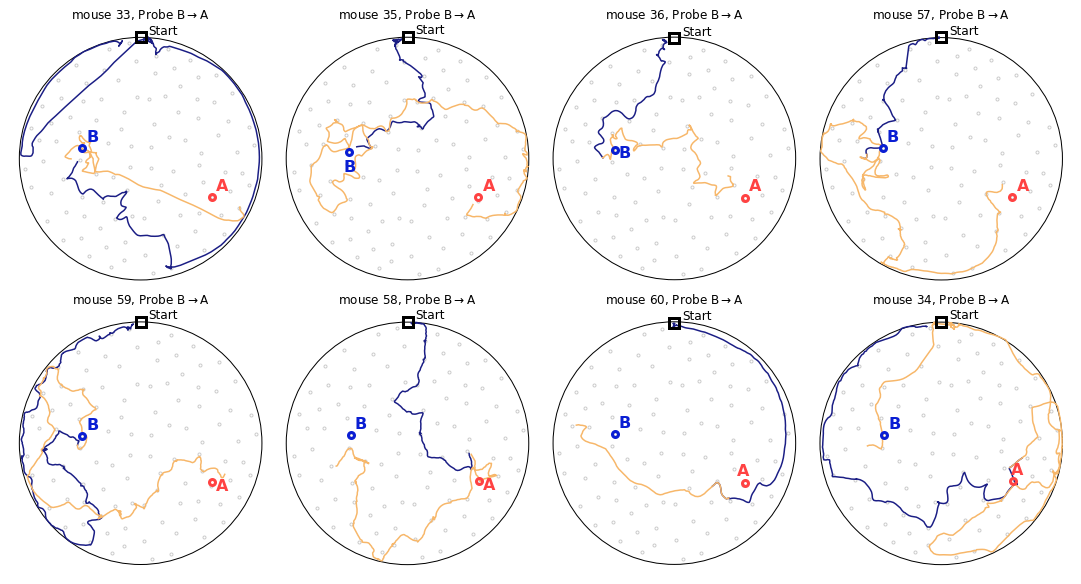

In [2]:
#import sys
#if 'modules.plot_func' in sys.modules.keys():
#    del sys.modules['modules.plot_func']
#if pltt:
#    del pltt
#import modules.plot_func as pltt

hole_horizon          = 10.0 # cm
time_delay_after_food = 1.0 # sec
start_align_vector    = (0,1)

color_red    = numpy.array((255, 66, 66,255))/255
color_blue   = numpy.array(( 10, 30,211,255))/255
color_orange = pltt.get_gradient(10,'orange')[0]
ax,lines=pltt.plot_all_tracks_2targets(all_trials_p2_complete,hole_horizon,time_delay_after_food,start_align_vector=start_align_vector,
                                       traj1Args=dict(color=color_darkblue,
                                                      startArgs     = dict(marker='s',markeredgewidth=3,markersize=10,color='k',label='Start',labelArgs=dict(fontsize=12,va='bottom',ha='left',color='k',pad=(4,0)  )),
                                                      targetArgs    = dict(marker='o',markeredgewidth=3,markersize= 6,color=color_blue,label='B',    labelArgs=dict(fontsize=16,va='bottom',ha='left', fontweight='bold',color=color_blue,pad=(2,2))),
                                                      targetAltArgs = dict(marker='o',markeredgewidth=3,markersize= 6,color=color_red ,label='A',    labelArgs=dict(fontsize=16,va='bottom',ha='left', fontweight='bold',color=color_red ,pad=(2,2)))),
                                       traj2Args=dict(color=color_orange),
                                       probe_title='Probe B-A', fig_size=(22,12))#color_darkyellow))
text_h = [tt for tt in misc.flatten_list(lines) if (('text' in str(type(tt))) and (tt.get_text() != 'Start'))]
text_h[11].set(va='top')   # A,i=0,j=3
text_h[3].set(ha='center') # A,i=1,j=1
text_h[-3].set(va='top')   # A,i=1,j=2
text_h[-1].set(ha='right') # A,i=1,j=3
text_h[6].set(va='top')    # B,i=0,j=1
text_h[4].set(va='top',ha='center',position=numpy.array(text_h[4].get_position())-numpy.array((2,6)))    # B,i=0,j=0
ax = pltt.tight_arena_panels(ax,adjust_title_position=False,dy_amid_panels=0.02)


if save_output_figures:
    plt.savefig(  f'{output_dir}/twotargets_trajectories_3s.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

# probe trajectories with check holes

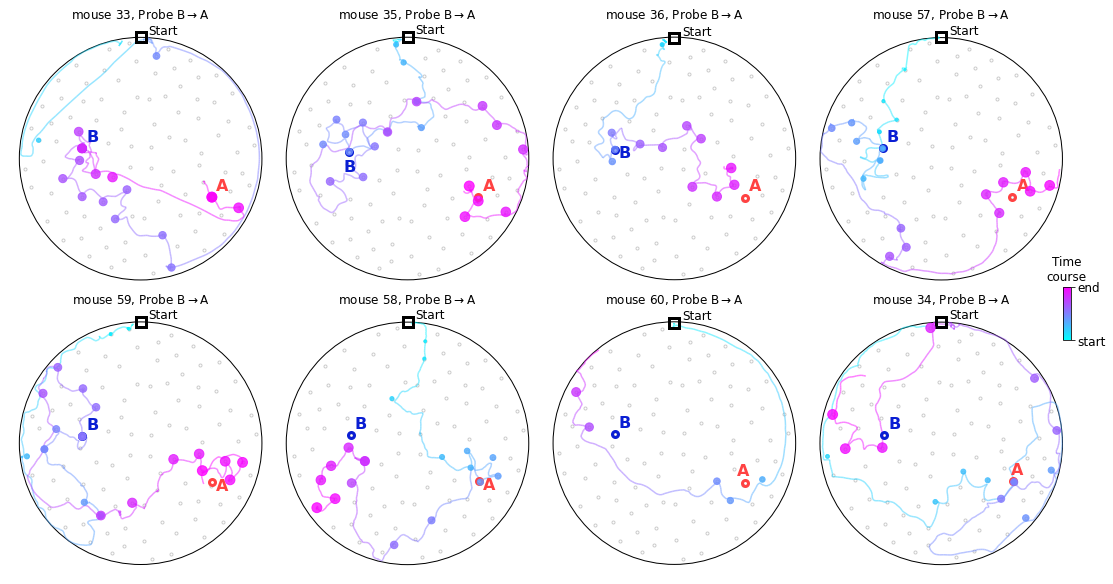

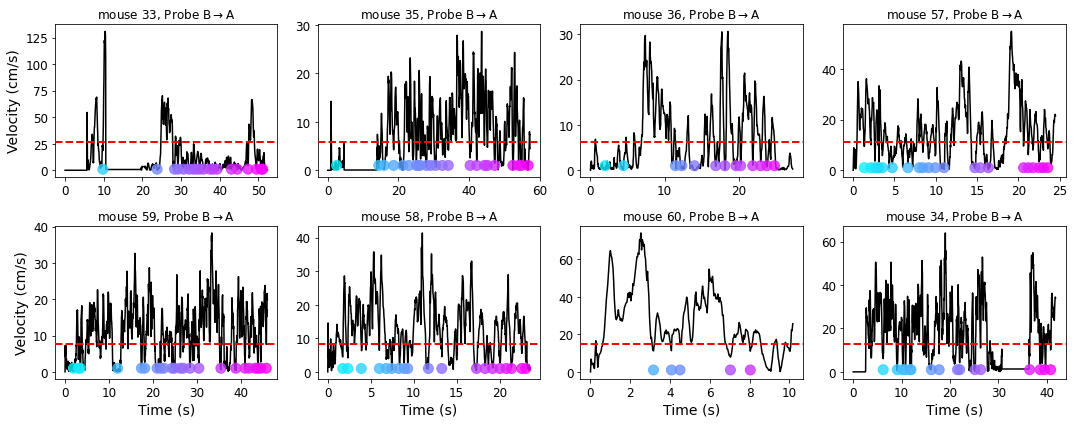

In [3]:
#import sys
#if 'modules.traj_analysis' in sys.modules.keys():
#    del sys.modules['modules.traj_analysis']
#if tran:
#    del tran
#import modules.traj_analysis as tran

trim_trajectories  = True
traj_alpha         = 0.5

hole_horizon          = 10.0 # cm
time_delay_after_food = 1.0 # sec
start_vec_align       = (0,1)

ignore_entrance_positions   = False
normalize_by                = 'max'
hole_horizon_hole_check     = 3.0 #cm
threshold_method            = 'ampv'
velocity_amplitude_fraction = 0.2
use_velocity_minima         = True
velocity_min_prominence     = 5.0 # cm/s

if trim_trajectories:
    tracks_to_plot = []
    for tr,tr_trim in zip(all_trials_p2_complete,all_trials_p2):
        t0 = 0.0 # seconds
        if (int(tr.mouse_number) == 35):
            t0 = 35.0 # the mouse doesn't move in the first 35 seconds
        if (int(tr.mouse_number) == 34):
            t0 = 20.0 # the mouse doesn't move in the first 35 seconds
        tr_new = tran.slice_track_by_time(tr,t0=t0,t1=tr_trim.time[-1]+1,copy_track=True)
        tr_new.time -= tr_new.time[0]
        tracks_to_plot.append(tr_new)
else:
    tracks_to_plot = copy.deepcopy(all_trials_p2_complete)

all_trials_p2_rot = plib.rotate_trial_file(tracks_to_plot,start_vec_align,True)
k_slow,t_slow,r_slow,v_th = misc.unpack_list_of_tuples([ tran.find_slowing_down_close_to_hole(tr,hole_horizon_hole_check,threshold_method=threshold_method,gamma=velocity_amplitude_fraction,
                                                                                                 return_pos_from='hole',ignore_entrance_positions=ignore_entrance_positions,
                                                                                                 use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for tr in all_trials_p2_rot ])


color_red    = numpy.array((255, 66, 66,255))/255
color_blue   = numpy.array(( 10, 30,211,255))/255
color_orange = pltt.get_gradient(10,'orange')[0]
ax,lines,panel_ind=pltt.plot_all_tracks_2targets(all_trials_p2_rot,hole_horizon,time_delay_after_food,
                                       traj1Args=dict(color                  = plt.get_cmap('cool'),
                                                      line_gradient_variable = 'time',
                                                      alpha                  = traj_alpha,
                                                      show_colorbar=False,
                                                      startArgs     = dict(marker='s',markeredgewidth=3,markersize=10,color='k'       ,label='Start',labelArgs=dict(fontsize=12,va='bottom',ha='left',                   color='k'       ,pad=(4,0))),
                                                      targetArgs    = dict(marker='o',markeredgewidth=3,markersize= 6,color=color_blue,label='B'    ,labelArgs=dict(fontsize=16,va='bottom',ha='left', fontweight='bold',color=color_blue,pad=(2,2))),
                                                      targetAltArgs = dict(marker='o',markeredgewidth=3,markersize= 6,color=color_red ,label='A'    ,labelArgs=dict(fontsize=16,va='bottom',ha='left', fontweight='bold',color=color_red ,pad=(2,2)))),
                                       traj2Args=dict(color=(0,0,0),alpha=traj_alpha),start_align_vector=start_vec_align,
                                       trim_trajectories=False,return_panel_ind=True,show_arena_holes=True,
                                       probe_title='Probe B-A',fig_size=(22,12))
text_h = [tt for tt in misc.flatten_list(lines) if (('text' in str(type(tt))) and (tt.get_text() != 'Start'))]
text_h[11].set(va='top')   # A,i=0,j=3
text_h[3].set(ha='center') # A,i=1,j=1
text_h[-3].set(va='top')   # A,i=1,j=2
text_h[-1].set(ha='right') # A,i=1,j=3
text_h[6].set(va='top')    # B,i=0,j=1
text_h[4].set(va='top',ha='center',position=numpy.array(text_h[4].get_position())-numpy.array((2,6)))    # B,i=0,j=0

for k,(ind,r,tr) in enumerate(zip(k_slow,r_slow,tracks_to_plot)):
    t_seq = tr.time[ind]/tr.time[-1]
    pltt.plot_trajectory_points(r,ax=ax.flatten()[panel_ind[int(tr.mouse_number)]],use_scatter=True,s=1e2*t_seq,marker='o',c=plt.get_cmap('cool')(t_seq),zorder=10000,alpha=0.8)


ax = pltt.tight_arena_panels(ax,adjust_title_position=False,dy_amid_panels=0.02)

cax = pltt._add_colorbar(ax[-1,-1],'cool',w_fraction_of_ax=0.03,h_fraction_of_ax=0.2,p0=(1.01,1.1),minmax_tick_labels=('start','end'),title='Time\ncourse',titleArgs=dict(color='k',fontsize=12),ticklabelsArgs=dict(color='k'))

if save_output_figures:
    detection_label = 'vmin' if use_velocity_minima else 'slowdown'
    plt.savefig(  f'{output_dir}/twotargets_trajectories_checks_3s_detection-{detection_label}.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')



fig,ax = plt.subplots(nrows=2,ncols=4,figsize=(15,6))
for k,(ind,tt_slow,vv_th,tr) in enumerate(zip(k_slow,t_slow,v_th,tracks_to_plot)):
    axh=ax.flatten()[panel_ind[int(tr.mouse_number)]]
    t_seq = tr.time[ind]/tr.time[-1]
    axh.plot(tr.time,tr.velocity,'-k')
    axh.scatter(tr.time[ind],numpy.ones(tr.velocity.size)[ind],s=100,marker='o',c=plt.get_cmap('cool')(t_seq),zorder=10000,alpha=0.8)
    axh.set_title('mouse %s, Probe B$\\rightarrow$A'%tr.mouse_number)
    pltt.plot_horizontal_lines(vv_th,ax=axh,xMin=axh.get_xlim()[0],xMax=axh.get_xlim()[1],linestyle='--',color='r',linewidth=2,zorder=20000)
    if panel_ind[int(tr.mouse_number)]>3:
        axh.set_xlabel('Time (s)')
    if (panel_ind[int(tr.mouse_number)] == 0) or (panel_ind[int(tr.mouse_number)] == 4):
        axh.set_ylabel('Velocity (cm/s)')

fig.tight_layout()

if save_output_figures:
    detection_label = 'vmin' if use_velocity_minima else 'slowdown'
    plt.savefig(  f'{output_dir}/twotargets_velocity_threshold_3s_detection-{detection_label}.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

# probe trajectors + check holes

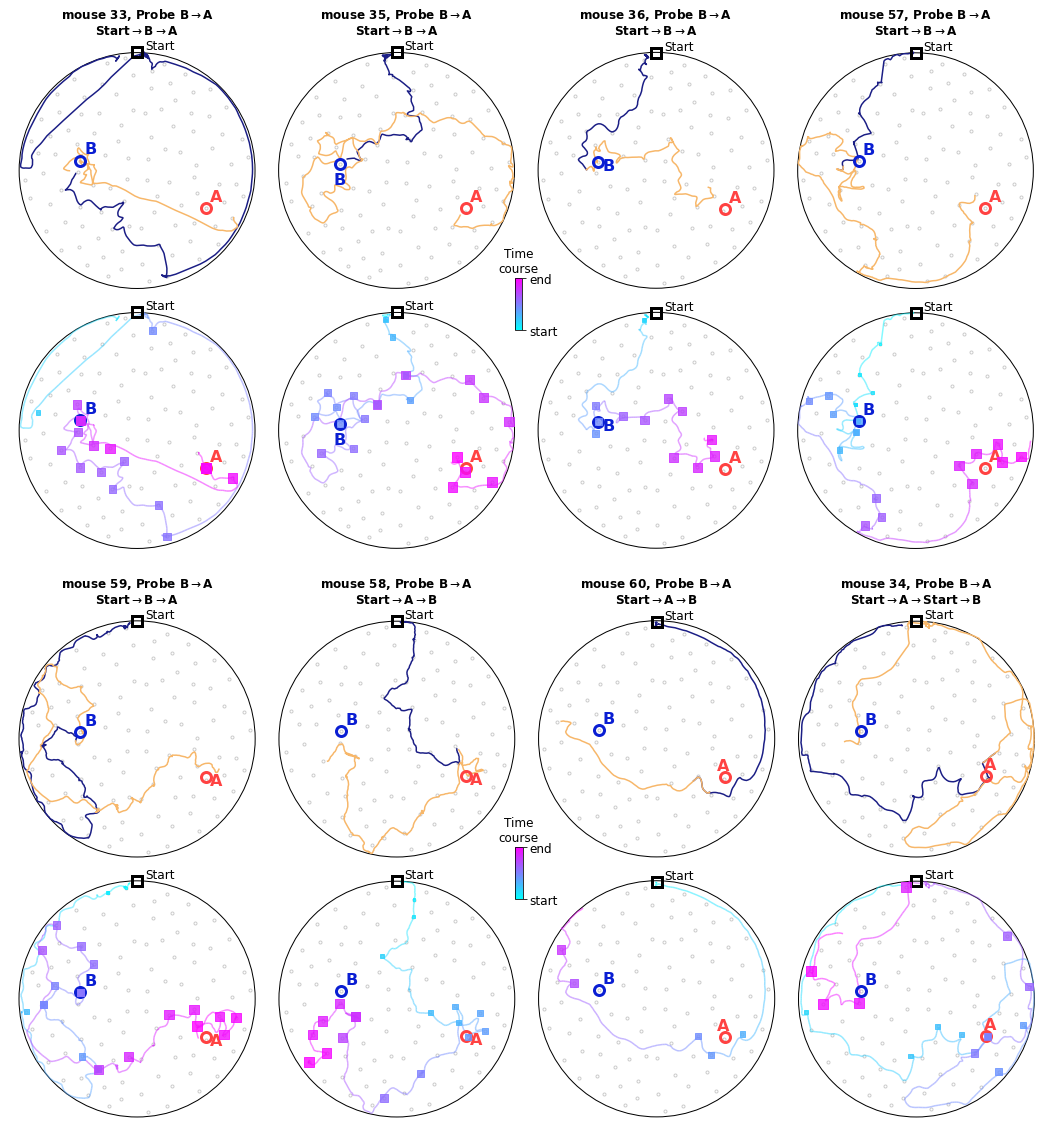

In [4]:

hole_horizon          = 10.0 # cm
time_delay_after_food = 1.0 # sec
start_align_vector    = (0,1)


fig,axes_to_plot = plt.subplots(nrows=4,ncols=4,figsize=(22,22))


color_red    = numpy.array((255, 66, 66,255))/255
color_blue   = numpy.array(( 10, 30,211,255))/255
color_orange = pltt.get_gradient(10,'orange')[0]
_,lines=pltt.plot_all_tracks_2targets(all_trials_p2_complete,hole_horizon,time_delay_after_food,start_align_vector=start_align_vector,
                                       traj1Args=dict(color=color_darkblue,
                                                      startArgs     = dict(marker='s',markeredgewidth=3,markersize=10,color='k',label='Start',labelArgs=dict(fontsize=12,va='bottom',ha='left',color='k',pad=(4,0)  )),
                                                      targetArgs    = dict(marker='o',markeredgewidth=3,markersize=10,color=color_blue,label='B',    labelArgs=dict(fontsize=16,va='bottom',ha='left', fontweight='bold',color=color_blue,pad=(2,2))),
                                                      targetAltArgs = dict(marker='o',markeredgewidth=3,markersize=10,color=color_red ,label='A',    labelArgs=dict(fontsize=16,va='bottom',ha='left', fontweight='bold',color=color_red ,pad=(2,2)))),
                                       traj2Args=dict(color=color_orange),
                                       probe_title='Probe B-A', axes_to_plot=axes_to_plot[:3:2,:], title_args=dict(fontweight='bold',fontsize=12))#color_darkyellow))
text_h = [tt for tt in misc.flatten_list(lines) if (('text' in str(type(tt))) and (tt.get_text() != 'Start'))]
text_h[11].set(va='top')   # A,i=0,j=3
text_h[3].set(ha='center') # A,i=1,j=1
text_h[-3].set(va='top')   # A,i=1,j=2
text_h[-1].set(ha='right') # A,i=1,j=3
text_h[6].set(va='top')    # B,i=0,j=1
text_h[4].set(va='top',ha='center',position=numpy.array(text_h[4].get_position())-numpy.array((2,6)))    # B,i=0,j=0




trim_trajectories  = True
traj_alpha         = 0.5

hole_horizon          = 10.0 # cm
time_delay_after_food = 1.0 # sec
start_vec_align       = (0,1)

ignore_entrance_positions   = False
normalize_by                = 'max'
hole_horizon_hole_check     = 3.0 #cm
threshold_method            = 'ampv'
velocity_amplitude_fraction = 0.2
use_velocity_minima         = True
velocity_min_prominence     = 5.0 # cm/s

if trim_trajectories:
    tracks_to_plot = []
    for tr,tr_trim in zip(all_trials_p2_complete,all_trials_p2):
        t0 = 0.0 # seconds
        if (int(tr.mouse_number) == 35):
            t0 = 35.0 # the mouse doesn't move in the first 35 seconds
        if (int(tr.mouse_number) == 34):
            t0 = 20.0 # the mouse doesn't move in the first 35 seconds
        tr_new = tran.slice_track_by_time(tr,t0=t0,t1=tr_trim.time[-1]+1,copy_track=True)
        tr_new.time -= tr_new.time[0]
        tracks_to_plot.append(tr_new)
else:
    tracks_to_plot = copy.deepcopy(all_trials_p2_complete)

all_trials_p2_rot = plib.rotate_trial_file(tracks_to_plot,start_vec_align,True)
k_slow,t_slow,r_slow,v_th = misc.unpack_list_of_tuples([ tran.find_slowing_down_close_to_hole(tr,hole_horizon_hole_check,threshold_method=threshold_method,gamma=velocity_amplitude_fraction,
                                                                                                 return_pos_from='hole',ignore_entrance_positions=ignore_entrance_positions,
                                                                                                 use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for tr in all_trials_p2_rot ])


color_red    = numpy.array((255, 66, 66,255))/255
color_blue   = numpy.array(( 10, 30,211,255))/255
color_orange = pltt.get_gradient(10,'orange')[0]
ax,lines,panel_ind=pltt.plot_all_tracks_2targets(all_trials_p2_rot,hole_horizon,time_delay_after_food,
                                       traj1Args=dict(color                  = plt.get_cmap('cool'),
                                                      line_gradient_variable = 'time',
                                                      alpha                  = traj_alpha,
                                                      show_colorbar=False,
                                                      startArgs     = dict(marker='s',markeredgewidth=3,markersize=10,color='k',label='Start',labelArgs=dict(fontsize=12,va='bottom',ha='left',color='k',pad=(4,0)  )),
                                                      targetArgs    = dict(marker='o',markeredgewidth=3,markersize=10,color=color_blue,label='B',    labelArgs=dict(fontsize=16,va='bottom',ha='left', fontweight='bold',color=color_blue,pad=(2,2))),
                                                      targetAltArgs = dict(marker='o',markeredgewidth=3,markersize=10,color=color_red ,label='A',    labelArgs=dict(fontsize=16,va='bottom',ha='left', fontweight='bold',color=color_red ,pad=(2,2)))),
                                       traj2Args=dict(color=(0,0,0),alpha=traj_alpha),start_align_vector=start_vec_align,
                                       trim_trajectories=False,return_panel_ind=True,show_arena_holes=True,
                                       probe_title='Probe B-A', axes_to_plot=axes_to_plot[1:4:2,:], show_title=False)
text_h = [tt for tt in misc.flatten_list(lines) if (('text' in str(type(tt))) and (tt.get_text() != 'Start'))]
text_h[11].set(va='top')   # A,i=0,j=3
text_h[3].set(ha='center') # A,i=1,j=1
text_h[-3].set(va='top')   # A,i=1,j=2
text_h[-1].set(ha='right') # A,i=1,j=3
text_h[6].set(va='top')    # B,i=0,j=1
text_h[4].set(va='top',ha='center',position=numpy.array(text_h[4].get_position())-numpy.array((2,6)))    # B,i=0,j=0

for k,(ind,r,tr) in enumerate(zip(k_slow,r_slow,tracks_to_plot)):
    t_seq = tr.time[ind]/tr.time[-1]
    pltt.plot_trajectory_points(r,ax=ax.flatten()[panel_ind[int(tr.mouse_number)]],use_scatter=True,s=1e2*t_seq,marker='s',c=plt.get_cmap('cool')(t_seq),zorder=10000,alpha=0.8)


axes_to_plot[:2,:] = pltt.tight_arena_panels(axes_to_plot[:2,:],adjust_title_position=False,dy_amid_panels=0.0)
axes_to_plot[2:,:] = pltt.tight_arena_panels(axes_to_plot[2:,:],adjust_title_position=False,dy_amid_panels=0.0)
for i in range(2,4):
    for j in range(4):
        p0 = axes_to_plot[i,j].get_position()
        p = [ p0.x0, p0.y0+0.035, p0.width, p0.height ]
        axes_to_plot[i,j].set_position(p, which='both')

tt1 = axes_to_plot[0,0].get_title()+'\nStart$\\rightarrow$B$\\rightarrow$A'
tt2 = axes_to_plot[0,1].get_title()+'\nStart$\\rightarrow$B$\\rightarrow$A'
tt3 = axes_to_plot[0,2].get_title()+'\nStart$\\rightarrow$B$\\rightarrow$A'
tt4 = axes_to_plot[0,3].get_title()+'\nStart$\\rightarrow$B$\\rightarrow$A'
tt5 = axes_to_plot[2,0].get_title()+'\nStart$\\rightarrow$B$\\rightarrow$A'
tt6 = axes_to_plot[2,1].get_title()+'\nStart$\\rightarrow$A$\\rightarrow$B'
tt7 = axes_to_plot[2,2].get_title()+'\nStart$\\rightarrow$A$\\rightarrow$B'
tt8 = axes_to_plot[2,3].get_title()+'\nStart$\\rightarrow$A$\\rightarrow$Start$\\rightarrow$B'


axes_to_plot[0,0].set_title(tt1,fontweight='bold',fontsize=12)
axes_to_plot[0,1].set_title(tt2,fontweight='bold',fontsize=12)
axes_to_plot[0,2].set_title(tt3,fontweight='bold',fontsize=12)
axes_to_plot[0,3].set_title(tt4,fontweight='bold',fontsize=12)
axes_to_plot[2,0].set_title(tt5,fontweight='bold',fontsize=12)
axes_to_plot[2,1].set_title(tt6,fontweight='bold',fontsize=12)
axes_to_plot[2,2].set_title(tt7,fontweight='bold',fontsize=12)
axes_to_plot[2,3].set_title(tt8,fontweight='bold',fontsize=12)


axes_to_plot[0,0].set_ylabel('Sample trajectory')
axes_to_plot[1,0].set_ylabel('Time course')
axes_to_plot[2,0].set_ylabel('Sample trajectory')
axes_to_plot[3,0].set_ylabel('Time course')

cax = pltt._add_colorbar(axes_to_plot[1,1],'cool',w_fraction_of_ax=0.03,h_fraction_of_ax=0.2,p0=(1.01,1.1),minmax_tick_labels=('start','end'),title='Time\ncourse',titleArgs=dict(color='k',fontsize=12),ticklabelsArgs=dict(color='k'))
cax = pltt._add_colorbar(axes_to_plot[3,1],'cool',w_fraction_of_ax=0.03,h_fraction_of_ax=0.2,p0=(1.01,1.1),minmax_tick_labels=('start','end'),title='Time\ncourse',titleArgs=dict(color='k',fontsize=12),ticklabelsArgs=dict(color='k'))



if save_output_figures:
    plt.savefig(  f'{output_dir}/twotargets_trajectories_3s.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

# hole check video

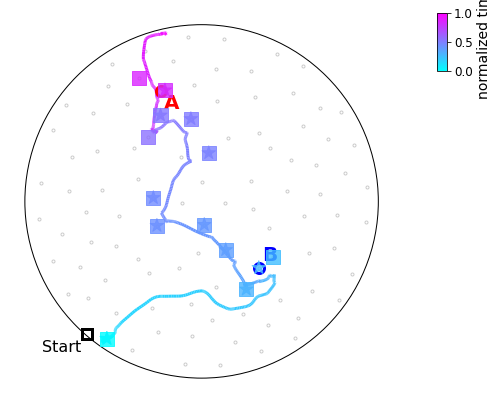

In [5]:
#import sys
#del sys.modules['modules.helper_func_class']
#del misc
#import modules.helper_func_class as misc
#
#import sys
#del sys.modules['modules.traj_analysis']
#del tran
#import modules.traj_analysis as tran

import scipy.io

# calculating hole check for mouse 36 to use as example

tr = tran.slice_track_by_time(all_trials_p2_complete[3],t0=0.0,t1=45.0,copy_track=True)

hole_horizon          = 10.0 # cm
time_delay_after_food = 1.0 # sec
start_vec_align       = (0,1)

ignore_entrance_positions   = False
normalize_by                = 'max'
hole_horizon_hole_check     = 3.0 #cm
threshold_method            = 'ampv'
velocity_amplitude_fraction = 0.2
use_velocity_minima         = True
velocity_min_prominence     = 5.0 # cm/s
join_vmin_vthresh_output    = False
k_slow,t_slow,r_slow,v_th   = tran.find_slowing_down_close_to_hole(tr,hole_horizon_hole_check,threshold_method=threshold_method,gamma=velocity_amplitude_fraction,
                                                                                                 return_pos_from='hole',ignore_entrance_positions=ignore_entrance_positions,
                                                                                                 use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence,join_vmin_vthresh_output=join_vmin_vthresh_output)

scipy.io.savemat('track_view/mouse_36_hole_checks_all_detections.mat',dict(k_slow=numpy.append(k_slow[0],k_slow[1]),t_slow=numpy.append(t_slow[0],t_slow[1]),r_slow=numpy.append(r_slow[0],r_slow[1],axis=0),v_th=v_th))
scipy.io.savemat('track_view/mouse_36_hole_checks_vel_min.mat'       ,dict(k_slow=k_slow[0]                        ,t_slow=t_slow[0]                        ,r_slow=r_slow[0]                               ,v_th=v_th))
scipy.io.savemat('track_view/mouse_36_hole_checks_vel_thresh.mat'    ,dict(k_slow=k_slow[1]                        ,t_slow=t_slow[1]                        ,r_slow=r_slow[1]                               ,v_th=v_th))

k_slow1 = k_slow[0]
k_slow2 = k_slow[1]
t_slow1 = t_slow[0]
t_slow2 = t_slow[1]
r_slow1 = r_slow[0]
r_slow2 = r_slow[1]

ax=pltt.plot_arena_sketch(tr,showHoles=True,showArenaCircle=True,showStart=True,
                          startArgs=dict(markersize=10,label='Start',labelArgs=dict(fontsize=16,va='top',ha='right',pad=(-2,-2))))
pltt.plot_mouse_trajectory(ax,tr,show_start=False,show_target=True,show_alt_target=True,color=plt.get_cmap('cool'),line_gradient_variable='time',linewidth=3,alpha=1.0,targetArgs=dict(marker='o',fillstyle='none',color='b',markeredgewidth=3,markersize=10,label='B',labelArgs=dict(fontweight='bold',fontsize=20,va='bottom',ha='left',pad=(1,1),color='b')),targetAltArgs=dict(marker='o',fillstyle='none',color='r',markeredgewidth=3,markersize=10,label='A',labelArgs=dict(fontweight='bold',fontsize=20,va='top',ha='left',pad=(1,-1),color='r')),show_colorbar=True)

t_seq = tr.time[k_slow1]/tr.time[-1]
pltt.plot_trajectory_points(r_slow1,ax=ax,use_scatter=True,s=200,marker='*',c=plt.get_cmap('cool')(t_seq),zorder=10000,alpha=0.8)

t_seq = tr.time[k_slow2]/tr.time[-1]
pltt.plot_trajectory_points(r_slow2,ax=ax,use_scatter=True,s=200,marker='s',c=plt.get_cmap('cool')(t_seq),zorder=10000,alpha=0.8)

pltt.tight_arena_panels(ax,set_axis_off=True)
plt.show()

# step gradient distance

(calculated in MATLAB from matrices generated in calc_step_probability_matrix)

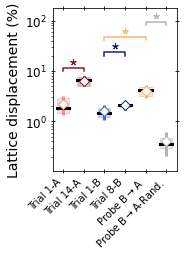

In [3]:
"""
###############
###############
###############
###############
############### step gradient matrix
###############
###############
############### the file loaded here was first calculated by calc_step_probability_matrix.py
############### then, it was processed and generated in step_prob_matrices_view/calc_step_displacement_barplot.m
###############
###############
###############
"""

input_file_data = misc.structtype()
input_file_data.Set(**{ k:v for k,v in scipy.io.loadmat('step_prob_matrices/step_gradient_displacement_boxplot_data.mat', squeeze_me=True).items() if k[0:2]!='__'})

# each entry in data is a vector of mouse values
data =  list(input_file_data.sample_step_displacement)

color_palette = [ color_lightred    ,
                  color_darkred     ,
                  color_lightblue   ,
                  color_darkblue    ,
                  color_orange  ,
                  color_gray]

data_labels = ['Trial 1-A', 'Trial 14-A', 'Trial 1-B', 'Trial 8-B', 'Probe B$\\rightarrow$A', 'Probe B$\\rightarrow$A-Rand.']

get_pvalue_matrix   = lambda data: numpy.array([ scipy.stats.ttest_ind(dd,misc.asarray_nanfill(data).T,equal_var=False,nan_policy='omit',alternative='two-sided').pvalue for dd in data ])
get_ttest_matrix    = lambda data: numpy.tril(misc.check_p_values(get_pvalue_matrix(data),p_significant,q_threshold=None),-1)
significance_matrix = get_ttest_matrix(data)
significance        = numpy.zeros(significance_matrix.shape)
significance[1,0]   = significance_matrix[1,0] # trial 1-A with last-A
significance[3,2]   = significance_matrix[3,2] # trial 1-B with last-B
significance[4,2]   = significance_matrix[4,2] # probe A-B with last-B
significance[5,4]   = significance_matrix[5,4] # probe A-B with random A-B


fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(FIGSIZE_1PANEL[0]/1.8,FIGSIZE_1PANEL[1]))
ax     = pltt.plot_boxplot(ax,data,data_labels,color_palette,significance,is_log_scale=True,boxplotargs=dict(widths=0.6,showfliers=False,flierprops=dict(marker='o',fillstyle='none'),boxprops=dict(linewidth=0.5,alpha=0.3)),errorbarargs=dict(markerfacecolor='w',markersize=7,marker='D'))
pltt.plot_horizontal_lines(0,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=-0.5,xMax=len(data)-0.5)
ax.set_yscale('log')
ax.set_xlim(-0.5,len(data)-0.5)
ax.set_xlabel('')
ax.set_ylabel('Lattice displacement (%)')
ax.tick_params(axis='x',which='major',rotation=45,top=True,direction='inout')
ax.tick_params(axis='y',which='major',right=True,direction='inout')
ax.set_xticklabels(data_labels, fontdict=dict(family='sans-serif',verticalalignment='top',horizontalalignment='right',size=10))

if save_output_figures:
    plt.savefig(  f'{output_dir}/twotargets_trials_box_step_grad_dist.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')
    plt.savefig(  'figs/paper/step_prob_typical_mouse/twotargets_trials_box_step_grad_dist.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

# d_perp PERPENDICULAR DISTANCE TO THE FOOD LINE


 Trial 8-B vs. Trial 1-B 	->	 p-value = 0.0021154403984944524
Probe B-A vs. Trial 1-B 	->	 p-value = 0.006776401605927579
Probe B-A-Rand. vs. Probe B-A 	->	 p-value = 0.0052846330130473735 



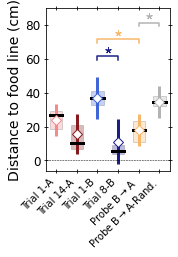

In [2]:
"""
###############
###############
###############
###############
############### d_perp PERPENDICULAR DISTANCE TO THE FOOD LINE
###############
###############
###############
###############
"""

n_trials_p2 = 1
n_trials_p3 = 1
n_trials    = n_trials_l1
n_trials_l2 = len(all_trials_l2)

d_perp_l1 = [ tran.calc_mouse_perp_dist_to_food_line(all_mice,return_abs_value=True) for all_mice in all_trials_l1 ]
d_perp_l2 = [ tran.calc_mouse_perp_dist_to_food_line(all_mice,return_abs_value=True) for all_mice in all_trials_l2 ]
d_perp_p2 = tran.calc_mouse_perp_dist_to_2target_line(all_trials_p2,return_abs_value=True)
d_perp_p3 = tran.calc_mouse_perp_dist_to_2target_line(all_trials_p3,return_abs_value=True)

d_perp_control_p2,_,_,_,_,_=tran.avg_value_over_displacement(all_trials_p2_complete, tran.calc_mouse_perp_dist_to_2target_line(all_trials_p2_complete,return_abs_value=True), d_food_baseline_p2, r0=None, n_r0_sample=10)
d_perp_control_p3,_,_,_,_,_=tran.avg_value_over_displacement(all_trials_p3_complete, tran.calc_mouse_perp_dist_to_2target_line(all_trials_p3_complete,return_abs_value=True), d_food_baseline_p2, r0=None, n_r0_sample=10)

# these variables are tables: rows -> mouse; col -> time
# each item of the lists obey this table pattern
d_perp_l1_trials_mice_vs_time = [ misc.asarray_nanfill(d) for d in d_perp_l1 ]
d_perp_l2_trials_mice_vs_time = [ misc.asarray_nanfill(d) for d in d_perp_l2 ]
d_perp_p2_mice_vs_time        =   misc.asarray_nanfill(d_perp_p2)
d_perp_p3_mice_vs_time        =   misc.asarray_nanfill(d_perp_p3)


#######
####### calculating time and mouse averages
#######

# each item in the list below containes the average d for each mice
d_perp_tmean_sd_err_p2 = misc.mean_std_err_minmax(d_perp_p2_mice_vs_time,axis=1)
d_perp_mmean_sd_err_p2 = numpy.array(misc.mean_std_err_minmax(d_perp_tmean_sd_err_p2[0]))[numpy.newaxis,:] # trial[0] -> mean of each mice
d_perp_tmean_sd_err_p3 = misc.mean_std_err_minmax(d_perp_p3_mice_vs_time,axis=1)
d_perp_mmean_sd_err_p3 = numpy.array(misc.mean_std_err_minmax(d_perp_tmean_sd_err_p3[0]))[numpy.newaxis,:] # trial[0] -> mean of each mice

d_perp_tmean_sd_err_l1 = [ misc.mean_std_err_minmax(misc.asarray_nanfill(all_mice),axis=1) for all_mice in d_perp_l1 ] # axis=1 -> average over time (tmean)
d_perp_tmean_l1        = misc.asarray_nanfill([ trial[0] for trial in d_perp_tmean_sd_err_l1 ])
d_perp_mmean_sd_err_l1 = numpy.array(misc.mean_std_err_minmax(d_perp_tmean_l1,axis=1)).T # trial[0] -> mean of each mice
d_perp_tmean_sd_err_l2 = [ misc.mean_std_err_minmax(misc.asarray_nanfill(all_mice),axis=1) for all_mice in d_perp_l2 ] # axis=1 -> average over time (tmean)
d_perp_tmean_l2        = misc.asarray_nanfill([ trial[0] for trial in d_perp_tmean_sd_err_l2 ])
d_perp_mmean_sd_err_l2 = numpy.array(misc.mean_std_err_minmax(d_perp_tmean_l2,axis=1)).T # trial[0] -> mean of each mice
# col0 -> mean
# col1 -> sd
# col2 -> se
# col3 -> min
# col4 -> max
# row -> trial (mean over mice)

# each entry in data is a vector of mouse values
data =  [ misc.nanmean(d_perp_l1_trials_mice_vs_time[0] ,axis=1),
          misc.nanmean(d_perp_l1_trials_mice_vs_time[13],axis=1),
          misc.nanmean(d_perp_l2_trials_mice_vs_time[0] ,axis=1),
          misc.nanmean(d_perp_l2_trials_mice_vs_time[-1],axis=1),
          misc.nanmean(d_perp_p2_mice_vs_time           ,axis=1),
          d_perp_control_p2]

color_palette = [ color_lightred    ,
                  color_darkred     ,
                  color_lightblue   ,
                  color_darkblue    ,
                  color_orange  ,
                  color_gray]

data_labels = ['Trial 1-A', 'Trial 14-A', 'Trial 1-B', 'Trial %d-B'%n_trials_l2, 'Probe B$\\rightarrow$A', 'Probe B$\\rightarrow$A-Rand.']

get_pvalue_matrix   = lambda data: numpy.array([ scipy.stats.ttest_ind(dd,misc.asarray_nanfill(data).T,equal_var=False,nan_policy='omit',alternative='two-sided').pvalue for dd in data ])
get_ttest_matrix    = lambda data: numpy.tril(misc.check_p_values(get_pvalue_matrix(data),p_significant,q_threshold=q_FDR),-1)
significance_matrix = get_ttest_matrix(data)
significance        = numpy.zeros(significance_matrix.shape)
significance[1,0]   = significance_matrix[1,0] # trial 1-A with last-A
significance[3,2]   = significance_matrix[3,2] # trial 1-B with last-B
significance[4,2]   = significance_matrix[4,2] # probe A-B with last-B
significance[5,4]   = significance_matrix[5,4] # probe A-B with random A-B

####### displaying p-values of the significant comparisons
if any(significance.flatten()):
    m,n                           = numpy.nonzero(significance)
    significance_labels           = numpy.array([ l.replace('$\\rightarrow$','-') for l in data_labels],dtype=str)
    significant_comparison_labels = [ f'{a} vs. {b}' for a,b in zip(significance_labels[m],significance_labels[n])]
    print('\n','\n'.join([ f'{a} \t->\t p-value = {b}' for a,b in zip(significant_comparison_labels,get_pvalue_matrix(data)[m,n]) ]),'\n')


fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(FIGSIZE_1PANEL[0]/1.8,FIGSIZE_1PANEL[1]))
ax     = pltt.plot_boxplot(ax,data,data_labels,color_palette,significance,boxplotargs=dict(widths=0.6,showfliers=False,flierprops=dict(marker='o',fillstyle='none'),boxprops=dict(linewidth=0.5,alpha=0.3)),errorbarargs=dict(markerfacecolor='w',markersize=7,marker='D'))
pltt.plot_horizontal_lines(0,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=-0.5,xMax=len(data)-0.5)
ax.set_xlim(-0.5,len(data)-0.5)
ax.set_xlabel('')
ax.set_ylabel('Distance to food line (cm)')
ax.tick_params(axis='x',which='major',rotation=45,top=True,direction='inout')
ax.tick_params(axis='y',which='major',right=True,direction='inout')
ax.set_xticklabels(data_labels, fontdict=dict(family='sans-serif',verticalalignment='top',horizontalalignment='right',size=10))

if save_output_figures:
    plt.savefig(  f'{output_dir}/twotargets_trials_box_perp_dist.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

# ha_cos HEADING ANGLE (AND COSINE)


 Trial 14-A vs. Trial 1-A 	->	 p-value = 0.02302305022207446
Trial 8-B vs. Trial 1-B 	->	 p-value = 0.0032948870220908494 



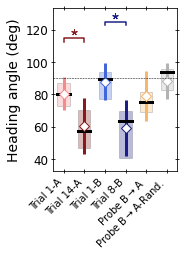

In [28]:
"""
###############
###############
###############
###############
############### ha_cos HEADING ANGLE (AND COSINE)
###############
###############
###############
###############
"""
n_trials_p2 = 1
n_trials_p3 = 1
n_trials    = n_trials_l1
n_trials_l2 = len(all_trials_l2)

ha_cos_l1 = [ tran.calc_mouse_deviation(all_mice,     absolute_food_vec=False,return_angle=False) for all_mice in all_trials_l1 ]
ha_cos_l2 = [ tran.calc_mouse_deviation(all_mice,     absolute_food_vec=False,return_angle=False) for all_mice in all_trials_l2 ]
ha_cos_p2 =   tran.calc_mouse_deviation(all_trials_p2,absolute_food_vec=False,return_angle=False,use_target_closest_to_end_position=True)
ha_cos_p3 =   tran.calc_mouse_deviation(all_trials_p3,absolute_food_vec=False,return_angle=False,use_target_closest_to_end_position=True)


ha_cos_control_p2,_,_,_,_,_ = tran.avg_value_over_displacement(all_trials_p2_complete, tran.calc_mouse_deviation(all_trials_p2_complete,absolute_food_vec=False,return_angle=False,use_target_closest_to_end_position=True), d_food_baseline_p2, r0=None, n_r0_sample=10, return_angle_from_cos=True)
ha_cos_control_p3,_,_,_,_,_ = tran.avg_value_over_displacement(all_trials_p3_complete, tran.calc_mouse_deviation(all_trials_p3_complete,absolute_food_vec=False,return_angle=False,use_target_closest_to_end_position=True), d_food_baseline_p2, r0=None, n_r0_sample=10, return_angle_from_cos=True)

ha_cos_mmean_control_p2 = misc.nanmean(misc.asarray_nanfill(ha_cos_control_p2)     ,axis=1)


# these variables are tables: rows -> mouse; col -> time
# each item of the lists obey this table pattern
ha_cos_l1_trials_mice_vs_time = [ misc.asarray_nanfill(d) for d in ha_cos_l1 ]
ha_cos_l2_trials_mice_vs_time = [ misc.asarray_nanfill(d) for d in ha_cos_l2 ]
ha_cos_p2_mice_vs_time        =   misc.asarray_nanfill(ha_cos_p2)
ha_cos_p3_mice_vs_time        =   misc.asarray_nanfill(ha_cos_p3)


#######
####### calculating time and mouse averages
#######

# each item in the list below containes the average d for each mice
ha_cos_tmean_sd_err_p2 = misc.mean_std_err_minmax(misc.asarray_nanfill(ha_cos_p2),axis=1)
ha_cos_mmean_sd_err_p2 = numpy.array(misc.avg_angle_from_cos(ha_cos_tmean_sd_err_p2[0],return_minmax=True))[numpy.newaxis,:] # trial[0] -> mean of each mice
ha_cos_tmean_sd_err_p3 = misc.mean_std_err_minmax(misc.asarray_nanfill(ha_cos_p3),axis=1)
ha_cos_mmean_sd_err_p3 = numpy.array(misc.avg_angle_from_cos(ha_cos_tmean_sd_err_p3[0],return_minmax=True))[numpy.newaxis,:] # trial[0] -> mean of each mice

ha_cos_tmean_sd_err_l1 = [ misc.mean_std_err_minmax(misc.asarray_nanfill(all_mice),axis=1) for all_mice in ha_cos_l1 ] # axis=1 -> average over time (tmean)
ha_cos_tmean_l1        = misc.asarray_nanfill([ trial[0] for trial in ha_cos_tmean_sd_err_l1 ])
ha_cos_mmean_sd_err_l1 = numpy.array(misc.avg_angle_from_cos(ha_cos_tmean_l1,axis=1,return_minmax=True)).T # trial[0] -> mean of each mice
ha_cos_tmean_sd_err_l2 = [ misc.mean_std_err_minmax(misc.asarray_nanfill(all_mice),axis=1) for all_mice in ha_cos_l2 ] # axis=1 -> average over time (tmean)
ha_cos_tmean_l2        = misc.asarray_nanfill([ trial[0] for trial in ha_cos_tmean_sd_err_l2 ])
ha_cos_mmean_sd_err_l2 = numpy.array(misc.avg_angle_from_cos(ha_cos_tmean_l2,axis=1,return_minmax=True)).T # trial[0] -> mean of each mice
# col0 -> mean
# col1 -> sd
# col2 -> se
# col3 -> min
# col4 -> max
# row -> trial (mean over mice)


data = [misc.avg_angle_from_cos(ha_cos_l1_trials_mice_vs_time[0] ,axis=1)[0],
        misc.avg_angle_from_cos(ha_cos_l1_trials_mice_vs_time[13],axis=1)[0],
        misc.avg_angle_from_cos(ha_cos_l2_trials_mice_vs_time[0] ,axis=1)[0],
        misc.avg_angle_from_cos(ha_cos_l2_trials_mice_vs_time[-1],axis=1)[0],
        misc.avg_angle_from_cos(ha_cos_p2_mice_vs_time           ,axis=1)[0],
        ha_cos_mmean_control_p2]

data_std = [misc.avg_angle_from_cos(misc.nanmean(ha_cos_l1_trials_mice_vs_time[0] ,axis=1))[1],
            misc.avg_angle_from_cos(misc.nanmean(ha_cos_l1_trials_mice_vs_time[13],axis=1))[1],
            misc.avg_angle_from_cos(misc.nanmean(ha_cos_l2_trials_mice_vs_time[0] ,axis=1))[1],
            misc.avg_angle_from_cos(misc.nanmean(ha_cos_l2_trials_mice_vs_time[-1],axis=1))[1],
            misc.avg_angle_from_cos(misc.nanmean(ha_cos_p2_mice_vs_time           ,axis=1))[1],
            misc.nanstd(ha_cos_mmean_control_p2)]

color_palette = [ color_lightred    ,
                  color_darkred     ,
                  color_lightblue   ,
                  color_darkblue    ,
                  color_orange      ,
                  color_gray        ]

data_labels = ['Trial 1-A', 'Trial 14-A', 'Trial 1-B', 'Trial %d-B'%n_trials_l2, 'Probe B$\\rightarrow$A', 'Probe B$\\rightarrow$A-Rand.']

get_pvalue_matrix = lambda data: numpy.array([ scipy.stats.ttest_ind(dd,misc.asarray_nanfill(data).T,equal_var=False,nan_policy='omit',alternative='two-sided').pvalue for dd in data ])
get_ttest_matrix  = lambda data: numpy.tril(misc.check_p_values(get_pvalue_matrix(data),p_significant,q_threshold=q_FDR),-1)
significance_matrix = get_ttest_matrix(data)
significance        = numpy.zeros(significance_matrix.shape)
significance[1,0]   = significance_matrix[1,0] # trial 1-A with last-A
significance[3,2]   = significance_matrix[3,2] # trial 1-B with last-B
significance[4,2]   = significance_matrix[4,2] # probe A-B with last-B
significance[5,4]   = significance_matrix[5,4] # probe A-B with random A-B


####### displaying p-values of the significant comparisons
if any(significance.flatten()):
    m,n                           = numpy.nonzero(significance)
    significance_labels           = numpy.array([ l.replace('$\\rightarrow$','-') for l in data_labels],dtype=str)
    significant_comparison_labels = [ f'{a} vs. {b}' for a,b in zip(significance_labels[m],significance_labels[n])]
    print('\n','\n'.join([ f'{a} \t->\t p-value = {b}' for a,b in zip(significant_comparison_labels,get_pvalue_matrix(data)[m,n]) ]),'\n')
    

fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(FIGSIZE_1PANEL[0]/1.8,FIGSIZE_1PANEL[1]))
ax     = pltt.plot_boxplot(ax,data,data_labels,color_palette,significance,boxplotargs=dict(widths=0.6,showfliers=False,flierprops=dict(marker='o',fillstyle='none'),boxprops=dict(linewidth=0.5,alpha=0.3)),errorbarargs=dict(markerfacecolor='w',markersize=7,marker='D'))
pltt.plot_horizontal_lines(90,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=-0.5,xMax=len(data)-0.5)
ax.set_xlim(-0.5,len(data)-0.5)
ax.set_xlabel('')
ax.set_ylabel('Heading angle (deg)')
ax.tick_params(axis='x',which='major',rotation=45,top=True,direction='inout')
ax.tick_params(axis='y',which='major',right=True,direction='inout')
ax.set_xticklabels(data_labels, fontdict=dict(family='sans-serif',verticalalignment='top',horizontalalignment='right',size=10))

if save_output_figures:
    plt.savefig(  f'{output_dir}/twotargets_trials_box_head_angle.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

# d_food TOTAL DISTANCE TO GET TO THE FOOD


 Trial 14-A vs. Trial 1-A 	->	 p-value = 0.0442609456373058
Trial 8-B vs. Trial 1-B 	->	 p-value = 0.0010183463459411558
Probe B-A vs. Trial 1-B 	->	 p-value = 0.0012642952538748434
Probe B-A-Rand. vs. Probe B-A 	->	 p-value = 0.009475265791608586 



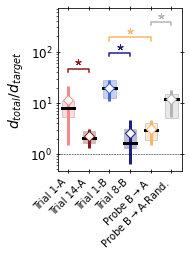

In [15]:
"""
###############
###############
###############
###############
############### d_food TOTAL DISTANCE TO GET TO THE FOOD
###############
###############
###############
###############
"""

n_trials_p2 = 1
n_trials_p3 = 1
n_trials    = n_trials_l1
n_trials_l2 = len(all_trials_l2)

d_food_l1 = [ tran.calc_traveled_dist(all_mice)     for all_mice in all_trials_l1 ]
d_food_l2 = [ tran.calc_traveled_dist(all_mice)     for all_mice in all_trials_l2 ]
d_food_p2 = numpy.array(  tran.calc_traveled_dist(all_trials_p2))[numpy.newaxis,:]
d_food_p3 = numpy.array(  tran.calc_traveled_dist(all_trials_p3))[numpy.newaxis,:]


d_food_control_p2,_,_,_,_,_ = tran.avg_value_over_displacement(all_trials_p2_complete, tran.calc_partial_traveled_dist(all_trials_p2_complete), d_food_baseline_p2, r0=None, n_r0_sample=10, subtract_x_in_r0=True)
d_food_control_p3,_,_,_,_,_ = tran.avg_value_over_displacement(all_trials_p3_complete, tran.calc_partial_traveled_dist(all_trials_p3_complete), d_food_baseline_p2, r0=None, n_r0_sample=10, subtract_x_in_r0=True)


#######
####### calculating time and mouse averages
#######

# each item in the list below containes the average d for each mice
d_food_tmean_sd_err_p2 = misc.mean_std_err_minmax(misc.asarray_nanfill(d_food_p2),axis=1)
d_food_mmean_sd_err_p2 = numpy.array(misc.mean_std_err_minmax(d_food_p2.flatten()))[numpy.newaxis,:] # trial[0] -> mean of each mice
d_food_tmean_sd_err_p3 = misc.mean_std_err_minmax(misc.asarray_nanfill(d_food_p3),axis=1)
d_food_mmean_sd_err_p3 = numpy.array(misc.mean_std_err_minmax(d_food_p3.flatten()))[numpy.newaxis,:] # trial[0] -> mean of each mice

d_food_mmean_sd_err_l1 = numpy.array(misc.mean_std_err_minmax(misc.asarray_nanfill(d_food_l1),axis=1)).T # trial[0] -> mean of each mice
d_food_mmean_sd_err_l2 = numpy.array(misc.mean_std_err_minmax(misc.asarray_nanfill(d_food_l2),axis=1)).T # trial[0] -> mean of each mice

# col0 -> mean
# col1 -> sd
# col2 -> se
# col3 -> min
# col4 -> max
# row -> trial (mean over mice)



data = [numpy.array(d_food_l1[0]) /d_food_baseline_l1,
        numpy.array(d_food_l1[13])/d_food_baseline_l1,
        numpy.array(d_food_l2[0]) /d_food_baseline_l2,
        numpy.array(d_food_l2[-1])/d_food_baseline_l2,
        d_food_p2.flatten()       /d_food_baseline_p2,
        d_food_control_p2         /d_food_baseline_p2#,
        #d_food_p3.flatten()       /d_food_baseline_p2,
        #d_food_control_p3         /d_food_baseline_p2
    ]

color_palette = [ color_lightred    ,
                  color_darkred     ,
                  color_lightblue   ,
                  color_darkblue    ,
                  color_orange      ,
                  color_gray        ]

data_labels = ['Trial 1-A', 'Trial 14-A', 'Trial 1-B', 'Trial %d-B'%n_trials_l2, 'Probe B$\\rightarrow$A', 'Probe B$\\rightarrow$A-Rand.']

get_pvalue_matrix = lambda data: numpy.array([ scipy.stats.ttest_ind(dd,misc.asarray_nanfill(data).T,equal_var=False,nan_policy='omit',alternative='two-sided').pvalue for dd in data ])
get_ttest_matrix  = lambda data: numpy.tril(misc.check_p_values(get_pvalue_matrix(data),p_significant,q_threshold=q_FDR),-1)
significance_matrix = get_ttest_matrix(data)
significance        = numpy.zeros(significance_matrix.shape)
significance[1,0]   = significance_matrix[1,0] # trial 1-A with last-A
significance[3,2]   = significance_matrix[3,2] # trial 1-B with last-B
significance[4,2]   = significance_matrix[4,2] # probe A-B with last-B
significance[5,4]   = significance_matrix[5,4] # probe A-B with random A-B

####### displaying p-values of the significant comparisons
if any(significance.flatten()):
    m,n                           = numpy.nonzero(significance)
    significance_labels           = numpy.array([ l.replace('$\\rightarrow$','-') for l in data_labels],dtype=str)
    significant_comparison_labels = [ f'{a} vs. {b}' for a,b in zip(significance_labels[m],significance_labels[n])]
    print('\n','\n'.join([ f'{a} \t->\t p-value = {b}' for a,b in zip(significant_comparison_labels,get_pvalue_matrix(data)[m,n]) ]),'\n')


fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(FIGSIZE_1PANEL[0]/1.8,FIGSIZE_1PANEL[1]))
ax     = pltt.plot_boxplot(ax,data,data_labels,color_palette,significance,is_log_scale=True,boxplotargs=dict(widths=0.6,showfliers=False,flierprops=dict(marker='o',fillstyle='none'),boxprops=dict(linewidth=0.5,alpha=0.3)),errorbarargs=dict(markerfacecolor='w',markersize=7,marker='D'))
pltt.plot_horizontal_lines(1,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=-0.5,xMax=len(data)-0.5)
ax.set_yscale('log')
ax.set_xlim(-0.5,len(data)-0.5)
ax.set_xlabel('')
ax.set_ylabel('$d_{total}/d_{target}$')#('Distance walked\nper target distance')
ax.tick_params(axis='x',which='major',rotation=45,top=True,direction='inout')
ax.tick_params(axis='y',which='major',right=True,direction='inout')
ax.set_xticklabels(data_labels, fontdict=dict(family='sans-serif',verticalalignment='top',horizontalalignment='right',size=10))

if save_output_figures:
    plt.savefig(  f'{output_dir}/twotargets_trials_box_d_food.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')


plt.show()

# t_food TIME TO GET TO THE FOOD

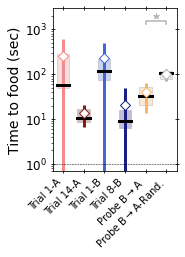

In [29]:
"""
###############
###############
###############
###############
############### t_food TIME TO GET TO THE FOOD
###############
###############
###############
###############
"""

n_trials_p2 = 1
n_trials_p3 = 1
n_trials    = n_trials_l1
n_trials_l2 = len(all_trials_l2)

t_food_l1 =             [ tran.calc_time_to_food(all_mice)     for all_mice in all_trials_l1 ]
t_food_l2 =             [ tran.calc_time_to_food(all_mice)     for all_mice in all_trials_l2 ]
t_food_p2 = numpy.array(  tran.calc_time_to_food(all_trials_p2))[numpy.newaxis,:]
t_food_p3 = numpy.array(  tran.calc_time_to_food(all_trials_p3))[numpy.newaxis,:]


t_food_control_p2,_,_,_,_,_=tran.avg_value_over_displacement(all_trials_p2_complete, [ tr.time for tr in all_trials_p2_complete ], d_food_baseline_p2, r0=None, n_r0_sample=10, subtract_x_in_r0=True)
t_food_control_p3,_,_,_,_,_=tran.avg_value_over_displacement(all_trials_p3_complete, [ tr.time for tr in all_trials_p3_complete ], d_food_baseline_p2, r0=None, n_r0_sample=10, subtract_x_in_r0=True)


#######
####### calculating time and mouse averages
#######

# each item in the list below containes the average d for each mice
t_food_tmean_sd_err_p2 = misc.mean_std_err_minmax(misc.asarray_nanfill(t_food_p2),axis=1)
t_food_mmean_sd_err_p2 = numpy.array(misc.mean_std_err_minmax(t_food_p2.flatten()))[numpy.newaxis,:] # trial[0] -> mean of each mice
t_food_tmean_sd_err_p3 = misc.mean_std_err_minmax(misc.asarray_nanfill(t_food_p3),axis=1)
t_food_mmean_sd_err_p3 = numpy.array(misc.mean_std_err_minmax(t_food_p3.flatten()))[numpy.newaxis,:] # trial[0] -> mean of each mice

t_food_mmean_sd_err_l1 = numpy.array(misc.mean_std_err_minmax(misc.asarray_nanfill(t_food_l1),axis=1)).T # trial[0] -> mean of each mice
t_food_mmean_sd_err_l2 = numpy.array(misc.mean_std_err_minmax(misc.asarray_nanfill(t_food_l2),axis=1)).T # trial[0] -> mean of each mice

# col0 -> mean
# col1 -> sd
# col2 -> se
# col3 -> min
# col4 -> max
# row -> trial (mean over mice)


data = [numpy.array(t_food_l1[0]) ,
        numpy.array(t_food_l1[13]),
        numpy.array(t_food_l2[0]) ,
        numpy.array(t_food_l2[-1]),
        t_food_p2.flatten()       ,
        t_food_control_p2         ]

color_palette = [ color_lightred    ,
                  color_darkred     ,
                  color_lightblue   ,
                  color_darkblue    ,
                  color_orange      ,
                  color_gray        ]

data_labels = ['Trial 1-A', 'Trial 14-A', 'Trial 1-B', 'Trial %d-B'%n_trials_l2, 'Probe B$\\rightarrow$A', 'Probe B$\\rightarrow$A-Rand.']

get_pvalue_matrix = lambda data: numpy.array([ scipy.stats.ttest_ind(dd,misc.asarray_nanfill(data).T,equal_var=False,nan_policy='omit',alternative='two-sided').pvalue for dd in data ])
get_ttest_matrix  = lambda data: numpy.tril(misc.check_p_values(get_pvalue_matrix(data),p_significant,q_threshold=q_FDR),-1)
significance_matrix = get_ttest_matrix(data)
significance        = numpy.zeros(significance_matrix.shape)
significance[1,0]   = significance_matrix[1,0] # trial 1-A with last-A
significance[3,2]   = significance_matrix[3,2] # trial 1-B with last-B
significance[4,2]   = significance_matrix[4,2] # probe A-B with last-B
significance[5,4]   = significance_matrix[5,4] # probe A-B with random A-B

fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(FIGSIZE_1PANEL[0]/1.8,FIGSIZE_1PANEL[1]))
ax     = pltt.plot_boxplot(ax,data,data_labels,color_palette,significance,is_log_scale=True,boxplotargs=dict(widths=0.6,showfliers=False,flierprops=dict(marker='o',fillstyle='none'),boxprops=dict(linewidth=0.5,alpha=0.3)),errorbarargs=dict(markerfacecolor='w',markersize=7,marker='D'))
pltt.plot_horizontal_lines(1,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=-0.5,xMax=len(data)-0.5)
ax.set_xlim(-0.5,len(data)-0.5)
ax.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('Time to food (sec)')
ax.tick_params(axis='x',which='major',rotation=45,top=True,direction='inout')
ax.tick_params(axis='y',which='major',right=True,direction='inout')
ax.set_xticklabels(data_labels, fontdict=dict(family='sans-serif',verticalalignment='top',horizontalalignment='right',size=10))

if save_output_figures:
    plt.savefig(  f'{output_dir}/twotargets_trials_box_t_food.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')




plt.show()

# vel VELOCITY

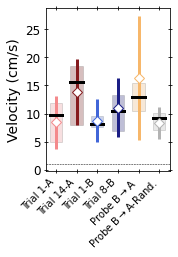

In [30]:
"""
###############
###############
###############
###############
############### vel VELOCITY
###############
###############
###############
###############
"""

n_trials_p2 = 1
n_trials_p3 = 1
n_trials    = n_trials_l1
n_trials_l2 = len(all_trials_l2)

# vel == time to get to the food
v_food_l1 =             [ tran.calc_mean_velocity(all_mice)     for all_mice in all_trials_l1 ]
v_food_l2 =             [ tran.calc_mean_velocity(all_mice)     for all_mice in all_trials_l2 ]
v_food_p2 = numpy.array(  tran.calc_mean_velocity(all_trials_p2))[numpy.newaxis,:]
v_food_p3 = numpy.array(  tran.calc_mean_velocity(all_trials_p3))[numpy.newaxis,:]


v_food_control_p2,_,_,_,_,_=tran.avg_value_over_displacement(all_trials_p2_complete, [ tr.velocity for tr in all_trials_p2_complete ], d_food_baseline_p2, r0=None, n_r0_sample=10)
v_food_control_p3,_,_,_,_,_=tran.avg_value_over_displacement(all_trials_p3_complete, [ tr.velocity for tr in all_trials_p3_complete ], d_food_baseline_p2, r0=None, n_r0_sample=10)


#######
####### calculating time and mouse averages
#######

# each item in the list below containes the average d for each mice
v_food_tmean_sd_err_p2 = misc.mean_std_err_minmax(misc.asarray_nanfill(v_food_p2),axis=1)
v_food_mmean_sd_err_p2 = numpy.array(misc.mean_std_err_minmax(v_food_p2.flatten()))[numpy.newaxis,:] # trial[0] -> mean of each mice
v_food_tmean_sd_err_p3 = misc.mean_std_err_minmax(misc.asarray_nanfill(v_food_p3),axis=1)
v_food_mmean_sd_err_p3 = numpy.array(misc.mean_std_err_minmax(v_food_p3.flatten()))[numpy.newaxis,:] # trial[0] -> mean of each mice

v_food_mmean_sd_err_l1 = numpy.array(misc.mean_std_err_minmax(misc.asarray_nanfill(v_food_l1),axis=1)).T # trial[0] -> mean of each mice
v_food_mmean_sd_err_l2 = numpy.array(misc.mean_std_err_minmax(misc.asarray_nanfill(v_food_l2),axis=1)).T # trial[0] -> mean of each mice

# col0 -> mean
# col1 -> sd
# col2 -> se
# col3 -> min
# col4 -> max
# row -> trial (mean over mice)



data = [numpy.array(v_food_l1[0]) ,
        numpy.array(v_food_l1[13]),
        numpy.array(v_food_l2[0]) ,
        numpy.array(v_food_l2[-1]),
        v_food_p2.flatten()       ,
        v_food_control_p2         ]

color_palette = [ color_lightred    ,
                  color_darkred     ,
                  color_lightblue   ,
                  color_darkblue    ,
                  color_orange      ,
                  color_gray        ]

data_labels = ['Trial 1-A', 'Trial 14-A', 'Trial 1-B', 'Trial %d-B'%n_trials_l2, 'Probe B$\\rightarrow$A', 'Probe B$\\rightarrow$A-Rand.']

get_pvalue_matrix = lambda data: numpy.array([ scipy.stats.ttest_ind(dd,misc.asarray_nanfill(data).T,equal_var=False,nan_policy='omit',alternative='two-sided').pvalue for dd in data ])
get_ttest_matrix  = lambda data: numpy.tril(misc.check_p_values(get_pvalue_matrix(data),p_significant,q_threshold=q_FDR),-1)
significance_matrix = get_ttest_matrix(data)
significance        = numpy.zeros(significance_matrix.shape)
significance[1,0]   = significance_matrix[1,0] # trial 1-A with last-A
significance[3,2]   = significance_matrix[3,2] # trial 1-B with last-B
significance[4,2]   = significance_matrix[4,2] # probe A-B with last-B
significance[5,4]   = significance_matrix[5,4] # probe A-B with random A-B

fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(FIGSIZE_1PANEL[0]/1.8,FIGSIZE_1PANEL[1]))
ax     = pltt.plot_boxplot(ax,data,data_labels,color_palette,significance,boxplotargs=dict(widths=0.6,showfliers=False,flierprops=dict(marker='o',fillstyle='none'),boxprops=dict(linewidth=0.5,alpha=0.3)),errorbarargs=dict(markerfacecolor='w',markersize=7,marker='D'))
pltt.plot_horizontal_lines(1,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=-0.5,xMax=len(data)-0.5)
ax.set_xlim(-0.5,len(data)-0.5)
ax.set_xlabel('')
ax.set_ylabel('Velocity (cm/s)')
ax.tick_params(axis='x',which='major',rotation=45,top=True,direction='inout')
ax.tick_params(axis='y',which='major',right=True,direction='inout')
ax.set_xticklabels(data_labels, fontdict=dict(family='sans-serif',verticalalignment='top',horizontalalignment='right',size=10))

if save_output_figures:
    plt.savefig(  f'{output_dir}/twotargets_trials_box_v_food.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

# n_holes NUMBER OF CHECKED HOLES PER UNIT DISTANCE


 Probe B-A-Rand. vs. Probe B-A 	->	 p-value = 0.0038669880254882825 



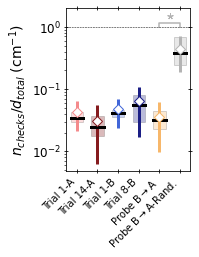

In [19]:
"""
###############
###############
###############
###############
############### n_holes NUMBER OF CHECKED HOLES PER UNIT DISTANCE TRAVELED
###############
###############
###############
###############
"""

n_trials_p2 = 1
n_trials_p3 = 1
n_trials    = n_trials_l1
n_trials_l2 = len(all_trials_l2)

# calculating the slowing down instants and positions in the 3 cm radius of holes
hole_horizon = 3.0 # in cm (units is mouse.unit_r)
#slo_st_rt = [ misc.structtype(struct_fields=['tind','t','r','v_th'],field_values=tran.find_slowing_down_close_to_hole(all_mice,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='mouse')) for all_mice in all_trials_rt ]
#slo_st_ft = [ misc.structtype(struct_fields=['tind','t','r','v_th'],field_values=tran.find_slowing_down_close_to_hole(all_mice,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='mouse')) for all_mice in all_trials_ft ]
n_holes_l1 = [ tran.calc_number_checked_holes_per_dist(all_mice,hole_horizon,threshold_method='ampv',gamma=0.1) for all_mice in all_trials_l1 ]
n_holes_l2 = [ tran.calc_number_checked_holes_per_dist(all_mice,hole_horizon,threshold_method='ampv',gamma=0.1) for all_mice in all_trials_l2 ]
n_holes_p2 = numpy.array(  tran.calc_number_checked_holes_per_dist(all_trials_p2,hole_horizon,threshold_method='ampv',gamma=0.1)  )[numpy.newaxis,:]
n_holes_p3 = numpy.array(  tran.calc_number_checked_holes_per_dist(all_trials_p3,hole_horizon,threshold_method='ampv',gamma=0.1)  )[numpy.newaxis,:]


n_holes_control_p2,d_mean_control_p2,_,_,_,_ = tran.avg_value_over_displacement(all_trials_p2_complete, tran.calc_number_checked_holes_per_dist(all_trials_p2_complete,hole_horizon,threshold_method='ampv',gamma=0.1,divide_by_total_distance=False,cumulative=True), d_food_baseline_p2, r0=None, n_r0_sample=10, subtract_x_in_r0=True)
n_holes_control_p3,d_mean_control_p3,_,_,_,_ = tran.avg_value_over_displacement(all_trials_p3_complete, tran.calc_number_checked_holes_per_dist(all_trials_p3_complete,hole_horizon,threshold_method='ampv',gamma=0.1,divide_by_total_distance=False,cumulative=True), d_food_baseline_p2, r0=None, n_r0_sample=10, subtract_x_in_r0=True)


#######
####### calculating time and mouse averages
#######


# each item in the list below containes the average d for each mice
n_holes_tmean_sd_err_p2 = misc.mean_std_err_minmax(misc.asarray_nanfill(n_holes_p2),axis=1)
n_holes_mmean_sd_err_p2 = numpy.array(misc.mean_std_err_minmax(n_holes_p2.flatten()))[numpy.newaxis,:] # trial[0] -> mean of each mice
n_holes_tmean_sd_err_p3 = misc.mean_std_err_minmax(misc.asarray_nanfill(n_holes_p3),axis=1)
n_holes_mmean_sd_err_p3 = numpy.array(misc.mean_std_err_minmax(n_holes_p3.flatten()))[numpy.newaxis,:] # trial[0] -> mean of each mice

n_holes_mmean_sd_err_l1 = numpy.array(misc.mean_std_err_minmax(misc.asarray_nanfill(n_holes_l1),axis=1)).T # trial[0] -> mean of each mice
n_holes_mmean_sd_err_l2 = numpy.array(misc.mean_std_err_minmax(misc.asarray_nanfill(n_holes_l2),axis=1)).T # trial[0] -> mean of each mice
# col0 -> mean
# col1 -> sd
# col2 -> se
# col3 -> min
# col4 -> max
# row -> trial (mean over mice)


data = [numpy.array(n_holes_l1[0]) ,
        numpy.array(n_holes_l1[13]),
        numpy.array(n_holes_l2[0]) ,
        numpy.array(n_holes_l2[-1]),
        n_holes_p2.flatten()       ,
        numpy.array(n_holes_control_p2)/numpy.array(d_mean_control_p2)]

color_palette = [ color_lightred    ,
                  color_darkred     ,
                  color_lightblue   ,
                  color_darkblue    ,
                  color_orange      ,
                  color_gray        ]

data_labels = ['Trial 1-A', 'Trial 14-A', 'Trial 1-B', 'Trial %d-B'%n_trials_l2, 'Probe B$\\rightarrow$A', 'Probe B$\\rightarrow$A-Rand.']

get_pvalue_matrix = lambda data: numpy.array([ scipy.stats.ttest_ind(dd,misc.asarray_nanfill(data).T,equal_var=False,nan_policy='omit',alternative='two-sided').pvalue for dd in data ])
get_ttest_matrix  = lambda data: numpy.tril(misc.check_p_values(get_pvalue_matrix(data),p_significant,q_threshold=q_FDR),-1)
significance_matrix = get_ttest_matrix(data)
significance        = numpy.zeros(significance_matrix.shape)
significance[1,0]   = significance_matrix[1,0] # trial 1-A with last-A
significance[3,2]   = significance_matrix[3,2] # trial 1-B with last-B
significance[4,2]   = significance_matrix[4,2] # probe A-B with last-B
significance[5,4]   = significance_matrix[5,4] # probe A-B with random A-B

####### displaying p-values of the significant comparisons
if any(significance.flatten()):
    m,n                           = numpy.nonzero(significance)
    significance_labels           = numpy.array([ l.replace('$\\rightarrow$','-') for l in data_labels],dtype=str)
    significant_comparison_labels = [ f'{a} vs. {b}' for a,b in zip(significance_labels[m],significance_labels[n])]
    print('\n','\n'.join([ f'{a} \t->\t p-value = {b}' for a,b in zip(significant_comparison_labels,get_pvalue_matrix(data)[m,n]) ]),'\n')

fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(FIGSIZE_1PANEL[0]/1.8,FIGSIZE_1PANEL[1]))
ax     = pltt.plot_boxplot(ax,data,data_labels,color_palette,significance,is_log_scale=True,boxplotargs=dict(widths=0.6,showfliers=False,flierprops=dict(marker='o',fillstyle='none'),boxprops=dict(linewidth=0.5,alpha=0.3)),errorbarargs=dict(markerfacecolor='w',markersize=7,marker='D'))
pltt.plot_horizontal_lines(1,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=-0.5,xMax=len(data)-0.5)
ax.set_xlim(-0.5,len(data)-0.5)
ax.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('$n_{checks}/d_{total}$ (cm$^{-1}$)')
ax.tick_params(axis='x',which='major',rotation=45,top=True,direction='inout')
ax.tick_params(axis='y',which='major',right=True,direction='inout')
ax.set_xticklabels(data_labels, fontdict=dict(family='sans-serif',verticalalignment='top',horizontalalignment='right',size=10))

if save_output_figures:
    plt.savefig(  f'{output_dir}/twotargets_trials_box_n_holes.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')




plt.show()

# Probability of hole checking vs distance to target

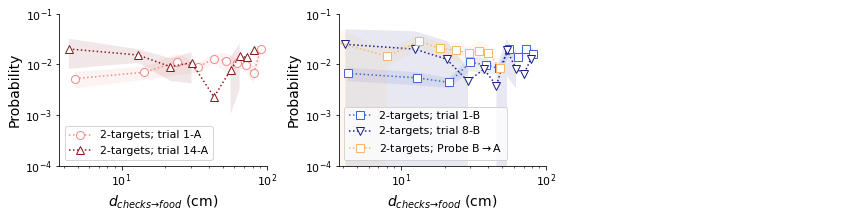

In [33]:
"""
###############
###############
###############
###############
############### P of d_holes -- real target, trimmed trajectories
###############
###############
###############
###############
"""

d_intertarget = plib.get_intertarget_distance_static_entrance()

align_entrances = False

ignore_entrance_positions = False

all_trials_l1_rot = plib.rotate_trial_file(copy.deepcopy(all_trials_l1),(-1,1),True)
all_trials_l2_rot = plib.rotate_trial_file(copy.deepcopy(all_trials_l2),(-1,1),True)
all_trials_p2_rot = plib.rotate_trial_file(copy.deepcopy(all_trials_p2),(-1,1),True)


# calculating the slowing down instants and positions in the 3 cm radius of holes
n_bins                  = 10
hole_horizon            = 3.0 # in cm (units is mouse.unit_r)  
use_velocity_minima     = True
velocity_min_prominence = 5.0 # cm/s

#######
####### calculating distributions
#######

d_holes_l1 = [ tran.calc_dist_checked_holes_target(all_mice         ,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice in all_trials_l1_rot ]
d_holes_l2 = [ tran.calc_dist_checked_holes_target(all_mice         ,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice in all_trials_l2_rot ]
d_holes_p2 =   tran.calc_dist_checked_holes_target(all_trials_p2_rot,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence,use_closest_target=True)

P_d_holes_l1 = [ tran.calc_distribution(all_mice  ,n_bins=n_bins,return_as_struct=True,binning='linear',join_samples=False,replace_Peq0_by_nan=True,remove_Peq0=True) for all_mice in d_holes_l1 ]
P_d_holes_l2 = [ tran.calc_distribution(all_mice  ,n_bins=n_bins,return_as_struct=True,binning='linear',join_samples=False,replace_Peq0_by_nan=True,remove_Peq0=True) for all_mice in d_holes_l2 ]
P_d_holes_p2 =   tran.calc_distribution(d_holes_p2,n_bins=n_bins,return_as_struct=True,binning='linear',join_samples=False,replace_Peq0_by_nan=True,remove_Peq0=True)


ax_label_fontsize = 14
ax_ticks_fontsize = 11


fh,axh = plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=2*FIGSIZE_1PANEL)
ax_pos = AX_POS_1PANEL.copy()
ax_pos[2] *= 0.8
ax_pos[3] *= 0.8
AX_POS_2PANELS_mod = numpy.array([   ax_pos/2.0,
                                 [ 1.5*ax_pos[0]+ax_pos[2]/2      ,ax_pos[1]/2,ax_pos[2]/2,ax_pos[3]/2 ],
                                 [ 1.75*1.5*ax_pos[0]+2*ax_pos[2]/2,ax_pos[1]/2,ax_pos[2]/2,ax_pos[3]/2 ] ])
axh[0].set_position(AX_POS_2PANELS_mod[0])
axh[1].set_position(AX_POS_2PANELS_mod[1])
axh[2].set_position(AX_POS_2PANELS_mod[2])
ax=axh[0]
pltt.plot_errorfill(P_d_holes_l1[0].x ,P_d_holes_l1[0].P ,P_d_holes_l1[0].Pse ,fmt=':o',ax=ax,color=color_lightred, markersize=8, markerfacecolor='w', alpha_fill=0.1, label='2-targets; trial 1-A')
pltt.plot_errorfill(P_d_holes_l1[13].x,P_d_holes_l1[13].P,P_d_holes_l1[13].Pse,fmt=':^',ax=ax,color=color_darkred , markersize=8, markerfacecolor='w', alpha_fill=0.1, label='2-targets; trial 14-A')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$d_{checks\\to food}$ (cm)', fontsize=ax_label_fontsize)
ax.set_ylabel('Probability',                fontsize=ax_label_fontsize)
ax.set_xlim(right=100)
ax.set_ylim((1e-4,1e-1))
ax.legend(loc='lower left',fontsize=11)
ax.tick_params(axis='y',   which='minor',length=0)
ax.tick_params(axis='both',which='major',labelsize=ax_ticks_fontsize)


ax=axh[1]
pltt.plot_errorfill(P_d_holes_l2[0].x ,P_d_holes_l2[0].P ,P_d_holes_l2[0].Pse ,fmt=':s',ax=ax,color=color_lightblue, markersize=8, markerfacecolor='w', alpha_fill=0.1, label='2-targets; trial 1-B')
pltt.plot_errorfill(P_d_holes_l2[-1].x,P_d_holes_l2[-1].P,P_d_holes_l2[-1].Pse,fmt=':v',ax=ax,color=color_darkblue , markersize=8, markerfacecolor='w', alpha_fill=0.1, label='2-targets; trial 8-B')
pltt.plot_errorfill(P_d_holes_p2.x    ,P_d_holes_p2.P    ,P_d_holes_p2.Pse    ,fmt=':s',ax=ax,color=color_orange   , markersize=8, markerfacecolor='w', alpha_fill=0.1, label='2-targets; Probe B$\\rightarrow$A')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$d_{checks\\to food}$ (cm)', fontsize=ax_label_fontsize)
ax.set_ylabel('Probability',                fontsize=ax_label_fontsize)
ax.set_xlim(right=100)
ax.set_ylim((1e-4,1e-1))
#ax.set_yticklabels(axh[0].get_yticklabels())
ax.yaxis.set_tick_params(labelleft=True)
ax.legend(loc='lower left',fontsize=11)
ax.tick_params(axis='y',   which='minor',length=0)
ax.tick_params(axis='both',which='major',labelsize=ax_ticks_fontsize)


axh[2].axis('off')



pltt.set_box_axis(axh,False)

if save_output_figures:
    plt.savefig(  f'{output_dir}/distribution_hole_distance_tgt-real_traj-trim.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

# (NEW) barplot near vs. far

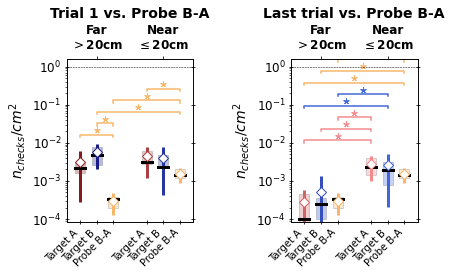

In [3]:
#import sys
#del sys.modules['modules.plot_func']
#del sys.modules['modules.helper_func_class']
#del pltt
#del misc
#import modules.plot_func as pltt
#import modules.helper_func_class as misc

"""
###############
###############
###############
###############
############### P of d_holes -- real target, trimmed trajectories
###############
###############
###############
###############
"""

calc_arena_area = lambda track: numpy.pi*(track.arena_diameter/2.0)**2

d_intertarget = plib.get_intertarget_distance_static_entrance()

align_entrances = False

ignore_entrance_positions = False

all_trials_l1_rot = plib.rotate_trial_file(copy.deepcopy(all_trials_l1),(-1,1),True)
all_trials_l2_rot = plib.rotate_trial_file(copy.deepcopy(all_trials_l2),(-1,1),True)
all_trials_p2_rot = plib.rotate_trial_file(copy.deepcopy(all_trials_p2),(-1,1),True)


# calculating the slowing down instants and positions in the 3 cm radius of holes
n_bins                  = 10
hole_horizon            = 3.0 # in cm (units is mouse.unit_r)  
use_velocity_minima     = True
velocity_min_prominence = 5.0 # cm/s


hole_proximity_radius_threshold = 20.0 # cm

area_arena    = calc_arena_area(all_trials_l1_rot[0][0])
area_near_tgt = numpy.pi * hole_proximity_radius_threshold**2
area_far_tgt  = area_arena - area_near_tgt

#######
####### calculating distributions
#######

d_holes_l1 = [ tran.calc_dist_checked_holes_target(all_mice         ,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice in all_trials_l1_rot ]
d_holes_l2 = [ tran.calc_dist_checked_holes_target(all_mice         ,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice in all_trials_l2_rot ]
d_holes_p2 =   tran.calc_dist_checked_holes_target(all_trials_p2_rot,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence,use_closest_target=True)

n_checks_near_l1 = numpy.asarray([ [ numpy.nonzero(d <= hole_proximity_radius_threshold)[0].size for d in trial      ] for trial in d_holes_l1 ],dtype=float)/area_near_tgt
n_checks_far_l1  = numpy.asarray([ [ numpy.nonzero(d  > hole_proximity_radius_threshold)[0].size for d in trial      ] for trial in d_holes_l1 ],dtype=float)/area_far_tgt
n_checks_near_l2 = numpy.asarray([ [ numpy.nonzero(d <= hole_proximity_radius_threshold)[0].size for d in trial      ] for trial in d_holes_l2 ],dtype=float)/area_near_tgt
n_checks_far_l2  = numpy.asarray([ [ numpy.nonzero(d  > hole_proximity_radius_threshold)[0].size for d in trial      ] for trial in d_holes_l2 ],dtype=float)/area_far_tgt
n_checks_near_p2 = numpy.asarray(  [ numpy.nonzero(d <= hole_proximity_radius_threshold)[0].size for d in d_holes_p2 ],dtype=float)/(2.0*area_near_tgt) # x2 because of two targets
n_checks_far_p2  = numpy.asarray(  [ numpy.nonzero(d  > hole_proximity_radius_threshold)[0].size for d in d_holes_p2 ],dtype=float)/(area_far_tgt-area_near_tgt) # discounting 2x the area near target because of 2 targets


far_near_label   = ['Far\n$>${:g}cm'.format(hole_proximity_radius_threshold),'Near\n$\\leq${:g}cm'.format(hole_proximity_radius_threshold)]


color_palette_l1 = pltt.get_gradient_between(color_darkred,color_lightred,4) #plt.get_cmap('tab20c')(numpy.linspace(0,1,20))[:4,:]
data_labels_l1   = ['Target A', 'Target A', 'Target A', 'Target A'] #['Trial 1 Far', 'Trial 1 Near', 'Trial 14 Far', 'Trial 14 Near']
data_l1          = [n_checks_far_l1[0]   ,
                    n_checks_near_l1[0]  ,
                    n_checks_far_l1[13]  ,
                    n_checks_near_l1[13] ]

color_palette_l2 = pltt.get_gradient_between(color_darkblue,color_lightblue,4) #plt.get_cmap('tab20c')(numpy.linspace(0,1,20))[4:8,:]
data_labels_l2   = ['Target B', 'Target B', 'Target B', 'Target B'] #['Trial 1 Far', 'Trial 1 Near', 'Trial 14 Far', 'Trial 14 Near']
data_l2          = [n_checks_far_l2[0]   ,
                    n_checks_near_l2[0]  ,
                    n_checks_far_l2[-1]  ,
                    n_checks_near_l2[-1] ]


color_palette_p2 = numpy.hstack((numpy.array([color_orange]*4),numpy.ones((4,1)))) #pltt.get_gradient_between(color_darkyellow,color_lightyellow,4) #plt.get_cmap('tab20c')(numpy.linspace(0,1,20))[4:8,:]
data_labels_p2   = ['Probe B-A', 'Probe B-A', 'Probe B-A', 'Probe B-A'] #['Trial 1 Far', 'Trial 1 Near', 'Trial 14 Far', 'Trial 14 Near']
data_p2          = [n_checks_far_p2  ,
                    n_checks_near_p2 ,
                    n_checks_far_p2  ,
                    n_checks_near_p2 ]



data          = misc.intertwin_vectors(data_l1,data_l2,data_p2,copy_data=True) #copy.deepcopy(data_rt)
data_labels   = misc.intertwin_vectors(data_labels_l1,data_labels_l2,data_labels_p2)
positions     = misc.intertwin_vectors(numpy.arange(0,15,4).astype(float),numpy.arange(0,15,4).astype(float)+1,numpy.arange(0,15,4).astype(float)+2)
color_palette = misc.intertwin_vectors(color_palette_l1,color_palette_l2,color_palette_p2)

get_pvalue_matrix        = lambda data: numpy.array([ scipy.stats.ttest_ind(dd,misc.asarray_nanfill(data).T,equal_var=False,nan_policy='omit',alternative='two-sided').pvalue for dd in data ])
get_ttest_matrix         = lambda data: numpy.tril(misc.check_p_values(get_pvalue_matrix(data),p_significant,q_threshold=q_FDR),-1)
significance_matrix      = get_ttest_matrix(data)  #numpy.zeros(significance_matrix.shape)
significance_trial1      = get_ttest_matrix(data[:6])
significance_trial1[list(set(range(6))-set([2,5])),:] = False # keeping only the interesting detected differences
significance_trial14     = get_ttest_matrix(data[6:])

ax_label_fontsize = 14
ax_ticks_fontsize = 11


fig,axh = plt.subplots(ncols=2,nrows=1,figsize=(2*FIGSIZE_1PANEL[0]/1.6,FIGSIZE_1PANEL[1]))


ax=axh[0]
ax     = pltt.plot_boxplot(ax,data[:6],data_labels[:6],color_palette[:6],significance_trial1,is_log_scale=True,positions=positions[:6],
                           boxplotargs  = dict(widths=0.6,showfliers=False,flierprops=dict(marker='o',fillstyle='none'),boxprops=dict(linewidth=0.5,alpha=0.3)),
                           errorbarargs = dict(markerfacecolor='w',markersize=7,marker='D'))
pltt.plot_horizontal_lines(1,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=-0.8,xMax=numpy.max(positions[:6])+0.8)
ax.set_title('Trial 1 vs. Probe B-A',fontsize=14,fontweight='bold')
ax.set_yscale('log')
ax.set_xlim(-0.8,numpy.max(positions[:6])+0.8)
ax.set_xlabel('')
ax.set_ylabel('$n_{checks}/cm^2$')#('Distance walked\nper target distance')
ax.tick_params(axis='x',which='major',rotation=45,top=True,direction='inout')
ax.tick_params(axis='y',which='major',right=True,direction='inout')
ax.set_xticklabels(data_labels[:6], fontdict=dict(family='sans-serif',verticalalignment='top',horizontalalignment='right',size=10))
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([1,5])
ax2.set_xticklabels(far_near_label, fontdict=dict(family='sans-serif',verticalalignment='bottom',horizontalalignment='center',size=12,fontweight='bold'))


ax = axh[1]
ax     = pltt.plot_boxplot(ax,data[6:],data_labels[6:],color_palette[6:],significance_trial14,is_log_scale=True,positions=positions[6:]-8.0,
                           boxplotargs  = dict(widths=0.6,showfliers=False,flierprops=dict(marker='o',fillstyle='none'),boxprops=dict(linewidth=0.5,alpha=0.3)),
                           errorbarargs = dict(markerfacecolor='w',markersize=7,marker='D'))
pltt.plot_horizontal_lines(1,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=-0.8,xMax=numpy.max(positions[6:])-8.0+0.8)
ax.set_title('Last trial vs. Probe B-A',fontsize=14,fontweight='bold')
ax.set_yscale('log')
ax.set_xlim(-0.8,numpy.max(positions[6:])-8.0+0.8)
ax.set_ylim(axh[0].get_ylim())
ax.set_xlabel('')
ax.set_ylabel('$n_{checks}/cm^2$')#('Distance walked\nper target distance')
ax.tick_params(axis='x',which='major',rotation=45,top=True,direction='inout')
ax.tick_params(axis='y',which='major',right=True,direction='inout')
ax.set_xticklabels(data_labels[6:], fontdict=dict(family='sans-serif',verticalalignment='top',horizontalalignment='right',size=10))
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([1,5])
ax2.set_xticklabels(far_near_label, fontdict=dict(family='sans-serif',verticalalignment='bottom',horizontalalignment='center',size=12,fontweight='bold'))
p  = ax.get_position()
ax.set_position([p.x0+0.2,p.y0,p.width,p.height])
ax2.set_position(ax.get_position())

save_output_figures=True
if save_output_figures:
    plt.savefig(  f'{output_dir}/NUM_checks_FAR_NEAR_2-tgt.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()